# One Dimensional scaling for u and v

## Imports

In [34]:
import sys
import os
import os.path
import io
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gamma
from scipy import integrate
import seaborn as sns
import numpy.random as nprand
from scipy.optimize import curve_fit
import matplotlib.ticker as mticker
from scipy.stats import gamma

## Read file

In [2]:
def readfiles1(pathtofile, file_name, ext_name,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    nbline=1
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                if nbline>=line_to_begin:
                    for j in range(len(lin)):
                        if ext_name == "allele":
                            if float(lin[5])>minq and float(lin[6])>minfert:
                                if withoutneutral==1 and float(lin[1]) != -3 :
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j])) 
                                elif withoutneutral==0:
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j]))
                        elif ext_name == "trace" and logfert==True and (j==6 or j==14):
                            data[params[j]].append(np.log(float(lin[j])))
                        else :
                            data[params[j]].append(float(lin[j]))
                nbline=nbline+1
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
                nbline=nbline+1
    return (data)

In [3]:
init_path="../../../"

## Parameters

In [4]:
N=5000
u=5e-5
v=2e-6
h=400
d=6
init_line=102
U=[2e-2,5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
V=[5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
folder_path_U=init_path+"analyses/scaling_bidim_U_V/scaling_bidim_1/scaling_V_2e-6/"
folder_path_V=init_path+"analyses/scaling_V/scaling_V_test/"
param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele","Fertility_allele",
                    "mean_affinity","q_analytic","fertility_analytic","relative_nb_meiosis","nb_linked_site",
                    "nb_linked_pos","absolute_nb_meiosis","cfree_ctot_hom","cfree_ctot_het","q_hom","q_het",
                    "fertility_hom","fertility_het","q_hom_analytic","q_het_analytique","fertility_hom_analytic",
                    "fertility_het_analytic","q_hemi_analytic","fertility_hemi_analytic","sigma",
                    "Fertility_individual","Fertility_individual_hom","Fertility_individual_het","Sym_active_pos",
                    "Asym_active_pos","Non_active_pos","nb_linked_pos_asym_active","nb_linked_site_asym_active"]
param_names_trace=["Generation_number","Total_number_of_allele","Diversity","Activity","Mean_Age","Time",
                   "Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q",
                   "q_intra","fertility_intra","q_analytic","fertility_analytic","q_sym","Fert_newall",
                   "Mean_c_occup_hom","Mean_c_occup_het","Mean_c_free_hom","Mean_c_free_het","Mean_sigma"]

folder_path_U_1=init_path+"analyses/scaling_U/scaling_U_19/"
folder_path_V_1=init_path+"analyses/scaling_V/scaling_V_19/"

## Functions useful for plot

In [5]:
def readscalingexperiment(target_folder_path , scaling_param_name, param_names_allele, param_names_trace,withoutneutral,init_line,logfert,errorbar_type):
    list_files = sorted(os.listdir(target_folder_path))
    stat_dict_allele = dict()
    for param in param_names_allele:
        stat_dict_allele[scaling_param_name]=[]
        stat_dict_allele[param+"_mean"]=[]
        stat_dict_allele[param+"_variance"]=[]
    stat_dict_trace = dict()
    for param in param_names_trace:
        stat_dict_trace[scaling_param_name]=[]
        stat_dict_trace[param+"_mean"]=[]
        stat_dict_trace[param+"_variance"]=[]
    for file_name in list_files :
        if file_name.split(".")[1]=="allele" :
            stat_dict_allele[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            data_file = readfiles1(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],withoutneutral,0,0,0,logfert,init_line)
            for key in data_file.keys():
                (stat_dict_allele[key+"_mean"]).append(np.mean(data_file[key]))
                if errorbar_type == "var":
                    (stat_dict_allele[key+"_variance"]).append(np.var(data_file[key]))
                elif errorbar_type == "std":
                    (stat_dict_allele[key+"_variance"]).append(np.std(data_file[key]))
                else :
                    print("Error : choose a type of errorbar between variance (var) and the standard variation (std)")
                    break
        elif file_name.split(".")[1]=="trace" :
            stat_dict_trace[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            data_file = readfiles1(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],withoutneutral,0,0,0,logfert,init_line)
            for key in data_file.keys():
                (stat_dict_trace[key+"_mean"]).append(np.mean(data_file[key]))
                if errorbar_type == "var":
                    (stat_dict_trace[key+"_variance"]).append(np.var(data_file[key]))
                elif errorbar_type == "std":
                    (stat_dict_trace[key+"_variance"]).append(np.std(data_file[key]))
                else :
                    print("Error : choose a type of errorbar between variance (var) and the standard variation (std)")
                    break
    return (stat_dict_allele,stat_dict_trace)

In [6]:
def simpson(f, a, b, n):
    pas = (b - a) / n
    somme = (f(a) + f(b)) / 2 + 2 * f(a + pas / 2)  # On initialise la somme
    x = a + pas           # La somme commence à x_1 
    for i in range(1, n): # On calcule la somme 
        somme += f(x) + 2 * f(x + pas / 2)
        x += pas
    return somme * pas / 3   # On retourne cette somme fois le pas / 3  

c=1
coeff_gamma=0.6
def gamma_func(aff):
    integral=1/coeff_gamma*np.exp(-aff*1/coeff_gamma)
    return integral

def x_0_func(aff):
    integral=(c*aff)/(1+c*aff)*gamma_func(aff)
    return integral
def x2_0_func(aff):
    integral=((c*aff)/(1+c*aff))**2*gamma_func(aff)
    return integral
def x3_0_func(aff):
    integral=((c*aff)/(1+c*aff))**3*gamma_func(aff)
    return integral
def x4_0_func(aff):
    integral=((c*aff)/(1+c*aff))**4*gamma_func(aff)
    return integral

# x_bar func with approx x_0
def x_bar_func(aff):
    integral=(c*aff)/(1+c*aff)*1/0.6*np.exp(-aff*1/0.6)*np.exp(-((c*aff)/(1+c*aff))/(x_0)*z_bar)
    return integral

def x2_bar_func(aff):
    integral=((c*aff)/(1+c*aff))**2*1/0.6*np.exp(-aff*1/0.6)*np.exp(-((c*aff)/(1+c*aff))/(x_0)*z_bar)
    return integral

def x3_bar_func(aff):
    integral=((c*aff)/(1+c*aff))**3*1/0.6*np.exp(-aff*1/0.6)*np.exp(-((c*aff)/(1+c*aff))/(x_0)*z_bar)
    return integral

# x_bar func with approx x_bar
def x_bar_func_1(aff):
    integral=(c*aff)/(1+c*aff)*1/0.6*np.exp(-aff*1/0.6)*np.exp(-((c*aff)/(1+c*aff))/(x_bar)*z_bar)
    return integral

def x2_bar_func_1(aff):
    integral=((c*aff)/(1+c*aff))**2*1/0.6*np.exp(-aff*1/0.6)*np.exp(-((c*aff)/(1+c*aff))/(x_bar)*z_bar)
    return integral

def x3_bar_func_1(aff):
    integral=((c*aff)/(1+c*aff))**3*1/0.6*np.exp(-aff*1/0.6)*np.exp(-((c*aff)/(1+c*aff))/(x_bar)*z_bar)
    return integral


def x_bar_func_gamma(aff):
    integral=(c*aff)/(1+c*aff)*gamma_func(aff)*np.exp(-((c*aff)/(1+c*aff))/(x_bar)*z_bar_test)
    return integral

def theta_mean_func(aff):
    integral=1/0.6*np.exp(-aff*1/0.6)*np.exp(-2*((c*aff)/(1+c*aff))/(x_0)*z_bar)
    return integral

def theta_mean_func_1(aff):
    integral=1/0.6*np.exp(-aff*1/0.6)*np.exp(-2*((c*aff)/(1+c*aff))/(x_bar)*z_bar)
    return integral

In [7]:
x_0=simpson(x_0_func, 0, 100, 1000)
x2_0=simpson(x2_0_func, 0, 100, 1000)
x3_0=simpson(x3_0_func, 0, 100, 1000)
x4_0=simpson(x4_0_func, 0, 100, 1000)
q_0=(2*x2_0-x3_0)/(x_0)
w_0=1-np.exp(-d*q_0)
beta_0=(-2*x3_0+x4_0+(2*x2_0**2)/(x_0)-(x3_0*x2_0)/(x_0))/(2*x_0**2)
alpha=abs((1/w_0)*d*beta_0*np.exp(-d*q_0))
rho=(N*v*d)/(2*h)
mu=4*N*u
z_bar=np.sqrt(rho/(mu*alpha))
print("mu=",mu)
print("rho=",rho)
print("q_0=",q_0)
print("beta=",beta_0)
print("alpha=",alpha)
print("z_bar=",z_bar)

mu= 1.0
rho= 7.5e-05
q_0= 0.643301494856534
beta= -0.05578573000857869
alpha= 0.007204932139082093
z_bar= 0.10202713331987563


## Minimum et maximum for u and v

In [8]:
# 1 < 4Nu < 100
u_min_4Nu = 1/(4*N)
print("u_min_4Nu = ",u_min_4Nu)
u_max_4Nu = 100/(4*N)
print("u_max_4Nu = ",u_max_4Nu)

# z_bar < 0.5
# pour u :
u_min_z_bar = v*d/(2*h*4*alpha*0.5*0.5)
print("u_min_z_bar = ",u_min_z_bar)
# pour v :
v_max_z_bar = 2*h*4*u*alpha*0.5*0.5/d
print("v_max_z_bar = ",v_max_z_bar)

# 4Ns > 3
min_s = 3
# pour u :
u_max_4Ns = v*d/(2*h*4*alpha*(min_s/(2*N*alpha))**2)
print("u_max_4Ns = ",u_max_4Ns)
# pour v :
v_min_4Ns = ((min_s/(2*N*alpha))**2)*2*h*4*u*alpha/d
print("v_min_4Ns = ",v_min_4Ns)

u_min = max(u_min_4Nu,u_min_z_bar)
u_max = min(u_max_4Nu,u_max_4Ns)
print("u_min = ",u_min," ; ","u_max = ",u_max)
v_min = v_min_4Ns
v_max = v_max_z_bar
print("v_min = ",v_min," ; ","v_max = ",v_max)

u_min_4Nu =  5e-05
u_max_4Nu =  0.005
u_min_z_bar =  2.0819071866943353e-06
v_max_z_bar =  4.803288092721395e-05
u_max_4Ns =  0.0003002055057950873
v_min_4Ns =  3.331051498710936e-07
u_min =  5e-05  ;  u_max =  0.0003002055057950873
v_min =  3.331051498710936e-07  ;  v_max =  4.803288092721395e-05


## Reading files

In [9]:
(allele_V,trace_V)=readscalingexperiment(target_folder_path=folder_path_V , scaling_param_name="V", param_names_allele=param_names_allele,param_names_trace=param_names_trace ,withoutneutral=0,init_line=init_line,logfert=0,errorbar_type="std")

In [10]:
(allele_V_1,trace_V_1)=readscalingexperiment(target_folder_path=folder_path_V_1 , scaling_param_name="V", param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele","Fertility_allele","mean_affinity","q_analytic","fertility_analytic"], param_names_trace=["Generation_number","Total_number_of_allele","Diversity","Activity","Mean_Age","Time","Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q","q_intra","fertility_intra","q_analytic","fertility_analytic","q_sym"],withoutneutral=0,init_line=init_line,logfert=0,errorbar_type="std")

In [11]:
(allele_U,trace_U)=readscalingexperiment(target_folder_path=folder_path_U , scaling_param_name="U", param_names_allele=param_names_allele,param_names_trace=param_names_trace ,withoutneutral=0,init_line=init_line,logfert=0,errorbar_type="std")

In [12]:
(allele_U_1,trace_U_1)=readscalingexperiment(target_folder_path=folder_path_U_1 , scaling_param_name="U", param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele","Fertility_allele","mean_affinity","q_analytic","fertility_analytic"], param_names_trace=["Generation_number","Total_number_of_allele","Diversity","Activity","Mean_Age","Time","Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q","q_intra","fertility_intra","q_analytic","fertility_analytic","q_sym"],withoutneutral=0,init_line=init_line,logfert=0,errorbar_type="std")

/home/agenestier/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/agenestier/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/agenestier/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/agenestier/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/agenestier/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
(allele_U_log,trace_U_log)=readscalingexperiment(target_folder_path=folder_path_U , scaling_param_name="U", param_names_allele=param_names_allele,param_names_trace=param_names_trace,withoutneutral=0,init_line=init_line,logfert=1,errorbar_type="std")

In [14]:
(allele_V_log,trace_V_log)=readscalingexperiment(target_folder_path=folder_path_V , scaling_param_name="V", param_names_allele=param_names_allele,param_names_trace=param_names_trace,withoutneutral=0,init_line=init_line,logfert=1,errorbar_type="std")

## Scaling diversity (D) in function of v

### Analytic data

In [15]:
V=[5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
D_V=[]
for i in V :
    D_V.append(max(1,24*N*u))

### Simulated data and graphic

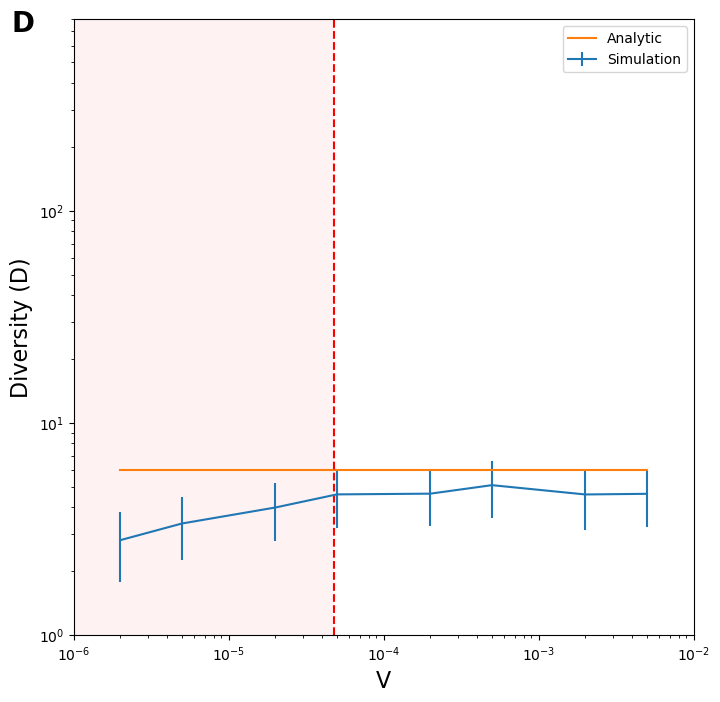

In [16]:
scaling_param_name="V"
param_to_plot="Diversity"
paramname="Diversity (D)"

figure=plt.figure(1, figsize=(8,8))
figure.patch.set_facecolor('white')
figure.patch.set_alpha(0)

cletodelete=[]
for cle in trace_V:
    if len(trace_V[cle])==0:
        cletodelete.append(cle)
for cle in cletodelete:
    del trace_V[cle]
df_trace_V = pd.DataFrame(trace_V,index = trace_V["V"])
df_trace_V.sort_values(by = "V", inplace = True)
plt.errorbar(df_trace_V[scaling_param_name], df_trace_V[param_to_plot+'_mean'], df_trace_V[param_to_plot+'_variance'],label="Simulation")

plt.text(x=0.0000004,y=700,s="D",fontweight='bold',fontsize=20)
plt.plot(V,D_V,label="Analytic")
plt.xscale('log')
plt.yscale('log')
plt.ylabel(paramname, fontsize = 16)
plt.xlabel(scaling_param_name, fontsize = 16)
plt.axvline(x=v_min,color="red",ls="--")
plt.axvline(x=v_max,color="red",ls="--")
plt.ylim(1,800)
plt.xlim(1e-6,1e-2)
color_x=[1e-6,v_max]
color_y=[1,800]
x=np.arange(1e-6,v_max,0.000000001)
y1=800
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='red')
plt.legend()

plt.savefig('Diversity_V.png', dpi=200, bbox_inches='tight')

## Scaling diversity (D) in function of u

In [17]:
U=[5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
D_U=[]
for i in U :
    D_U.append(max(1,24*N*i))

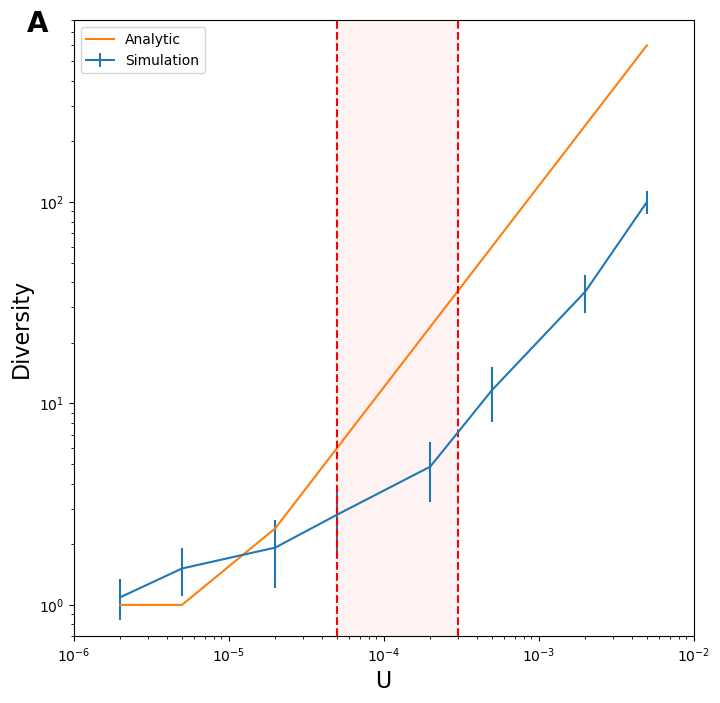

In [18]:
# Scaling diversity un function of u
scaling_param_name="U"
param_to_plot="Diversity"
paramname="Diversity"

cletodelete=[]
for cle in trace_U:
    if len(trace_U[cle])==0:
        cletodelete.append(cle)
for cle in cletodelete:
    del trace_U[cle]
df_trace_U = pd.DataFrame(trace_U,index = trace_U["U"])
df_trace_U.sort_values(by = "U", inplace = True)

figure=plt.figure(1, figsize=(8,8))
figure.patch.set_facecolor('white')
figure.patch.set_alpha(0)
plt.errorbar(df_trace_U[scaling_param_name], df_trace_U[param_to_plot+'_mean'], df_trace_U[param_to_plot+'_variance'],label="Simulation")
plt.text(x=0.0000005,y=700,s="A",fontweight='bold',fontsize=20)
plt.plot(U,D_U,label="Analytic")
plt.xscale('log')
plt.yscale('log')
plt.ylabel(paramname, fontsize = 16)
plt.xlabel(scaling_param_name, fontsize = 16)
plt.axvline(x=u_min,color="red",ls="--")
plt.axvline(x=u_max,color="red",ls="--")
plt.legend()
plt.ylim(0.7,800)
plt.xlim(1e-6,1e-2)
x=np.arange(u_min,u_max,0.000000001)
y1=800
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='red')

## Scaling mean cumulative erosion (z) in function of v

In [19]:
V1=[5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
Z_V_BAR=[]
ACT_V_BAR=[]
ALPHA_V=[]
X_V_BAR=[]
for j in V1 :
    print(j)
    x_bar=x_0
    rho=(N*j*d)/(2*h)
    mu=4*N*u
    q_0=(2*x2_0-x3_0)/(x_0)
    w_0=1-np.exp(-d*q_0)
    beta_0=(-2*x3_0+x4_0+(2*x2_0**2)/(x_0)-(x3_0*x2_0)/(x_0))/(2*x_0**2)
    alpha=abs((1/w_0)*d*beta_0*np.exp(-d*q_0))
    z_bar_test=np.sqrt(rho/(mu*alpha))
    print("z_0 = ",z_bar_test)
    for i in range(10):
        x_bar=simpson(x_bar_func_1, 0, 10, 100)
        beta_1=abs(((-2*x3_0+x4_0)*2*x_0+x2_0*(4*x2_0-2*x3_0))/((4*x2_0**2)*x_bar))
        alpha_1=abs((1/w_0)*d*beta_1*np.exp(-d*q_0))
        z_bar_test=np.sqrt(rho/(mu*alpha_1))
        print(z_bar_test)
    print("z = ",z_bar_test)
    Z_V_BAR.append(z_bar_test)
    print("beta = ",beta_1)
    print("alpha = ",alpha_1)
    ALPHA_V.append(alpha_1)
    print("act = ",np.exp(-z_bar_test))
    ACT_V_BAR.append(np.exp(-z_bar_test))
    print(x_bar)
    X_V_BAR.append(x_bar)

0.005
z_0 =  5.101356665993782
2.036228243809791
2.015258154369422
2.01192328924711
2.0113840122219293
2.0112965726375314
2.011282388841861
2.0112800878908557
2.011279714617297
2.011279654062593
2.011279644239037
z =  2.011279644239037
beta =  0.35888026881269375
alpha =  0.04635070621919566
act =  0.13381732648890624
0.26194243887302965
0.002
z_0 =  3.226381244284636
1.2878238172807186
1.2745611682069165
1.2724520143117244
1.2721109455738497
1.2720556439249788
1.2720466733049418
1.2720452180557493
1.2720449819768223
1.2720449436786647
1.2720449374657024
z =  1.2720449374657024
beta =  0.35888026881269375
alpha =  0.04635070621919566
act =  0.2802579254599211
0.26194243887302965
0.0005
z_0 =  1.613190622142318
0.6439119086403593
0.6372805841034582
0.6362260071558622
0.6360554727869249
0.6360278219624894
0.6360233366524709
0.6360226090278747
0.6360224909884111
0.6360224718393324
0.6360224687328512
z =  0.6360224687328512
beta =  0.35888026881269375
alpha =  0.04635070621919566
act =  0.

In [20]:
V=[5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
Z_V=[]
Zapprox_V=[]
mu=4*N*u
for i in V :
    rho=(N*i*d)/(2*h)
    z_bar=np.sqrt(rho/(mu*alpha))
    Z_V.append(z_bar)
    Zapprox_V.append(1-np.exp(-z_bar))

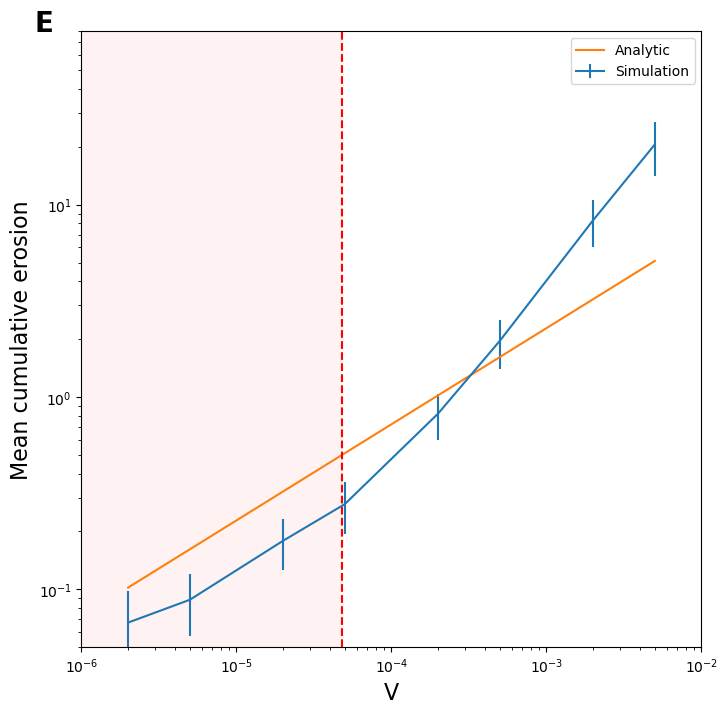

In [21]:
scaling_param_name="V"
param_to_plot="Mean_Age"
paramname="Mean cumulative erosion"

figure=plt.figure(1, figsize=(8,8))
figure.patch.set_facecolor('white')
figure.patch.set_alpha(0)

cletodelete=[]
for cle in trace_V:
    if len(trace_V[cle])==0:
        cletodelete.append(cle)
for cle in cletodelete:
    del trace_V[cle]
df_trace_V = pd.DataFrame(trace_V,index = trace_V["V"])
df_trace_V.sort_values(by = "V", inplace = True)
plt.errorbar(df_trace_V[scaling_param_name], df_trace_V[param_to_plot+'_mean'], df_trace_V[param_to_plot+'_variance'],label="Simulation")

plt.plot(V,Z_V,label="Analytic")
plt.text(x=0.0000005,y=80,s="E",fontweight='bold',fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(paramname, fontsize = 16)
plt.xlabel(scaling_param_name, fontsize = 16)
plt.axvline(x=v_min,color="red",ls="--")
plt.axvline(x=v_max,color="red",ls="--")
plt.legend()
plt.ylim(0.05,80)
plt.xlim(1e-6,1e-2)
x=np.arange(v_min,v_max,0.000000001)
y1=80
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='red')


plt.savefig('Mean_Age_V.png', dpi=200, bbox_inches='tight')

## Scaling mean cumulative erosion (z) in function of u

In [22]:
U1=[2e-2,5e-3,2e-3,5e-4,2e-4,5e-5,2e-5]
Z_U_BAR=[]
ACT_U_BAR=[]
ALPHA_U=[]
X_U_BAR=[]
for j in U1 :
    print(j)
    x_bar=x_0
    rho=(N*v*d)/(2*h)
    mu=4*N*j
    q_0=(2*x2_0-x3_0)/(x_0)
    w_0=1-np.exp(-d*q_0)
    beta_0=(-2*x3_0+x4_0+(2*x2_0**2)/(x_0)-(x3_0*x2_0)/(x_0))/(2*x_0**2)
    alpha=abs((1/w_0)*d*beta_0*np.exp(-d*q_0))
    z_bar_test=np.sqrt(rho/(mu*alpha))
    print("z_0 = ",z_bar_test)
    for i in range(20):
        x_bar=simpson(x_bar_func_gamma, 0, 10, 100)
        beta_1=abs(((-2*x3_0+x4_0)*2*x_0+x2_0*(4*x2_0-2*x3_0))/((4*x2_0**2)*x_bar))
        alpha_1=abs((1/w_0)*d*beta_1*np.exp(-d*q_0))
        z_bar_test=np.sqrt(rho/(mu*alpha_1))
        print(z_bar_test)
        print("x_bar")
        print(x_bar)
    print("z = ",z_bar_test)
    Z_U_BAR.append(z_bar_test)
    print("beta = ",beta_1)
    print("alpha = ",alpha_1)
    ALPHA_U.append(alpha_1)
    print("act = ",np.exp(-z_bar_test))
    ACT_U_BAR.append(np.exp(-z_bar_test))
    print("x_bar = " , x_bar)
    X_U_BAR.append(x_bar)

0.02
z_0 =  0.005101356665993781
0.0021759759618325083
x_bar
0.3065978726126805
0.002180365880112764
x_bar
0.30783621100507325
0.0021803725451468832
x_bar
0.30783809302130194
0.002180372555245748
x_bar
0.3078380958729388
0.00218037255526105
x_bar
0.3078380958772596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
0.0021803725552610727
x_bar
0.30783809587726596
z =  0.0021803

In [23]:
U=[5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
Z_U=[]
Zapprox_U=[]
rho=(N*v*d)/(2*h)
for i in U :
    mu=4*N*i
    z_bar=np.sqrt(rho/(mu*alpha))
    print("U=",i," ","mu=",mu," ","mu*alpha=",mu*alpha," ","quotient=",rho/(mu*alpha))
    Z_U.append(z_bar)
    Zapprox_U.append(1-np.exp(-z_bar))

U= 0.005   mu= 100.0   mu*alpha= 0.7204932139082093   quotient= 0.00010409535933471675
U= 0.002   mu= 40.0   mu*alpha= 0.2881972855632837   quotient= 0.0002602383983367919
U= 0.0005   mu= 10.0   mu*alpha= 0.07204932139082093   quotient= 0.0010409535933471677
U= 0.0002   mu= 4.0   mu*alpha= 0.02881972855632837   quotient= 0.002602383983367919
U= 5e-05   mu= 1.0   mu*alpha= 0.007204932139082093   quotient= 0.010409535933471676
U= 2e-05   mu= 0.4   mu*alpha= 0.002881972855632837   quotient= 0.02602383983367919
U= 5e-06   mu= 0.1   mu*alpha= 0.0007204932139082093   quotient= 0.10409535933471677
U= 2e-06   mu= 0.04   mu*alpha= 0.0002881972855632837   quotient= 0.2602383983367919


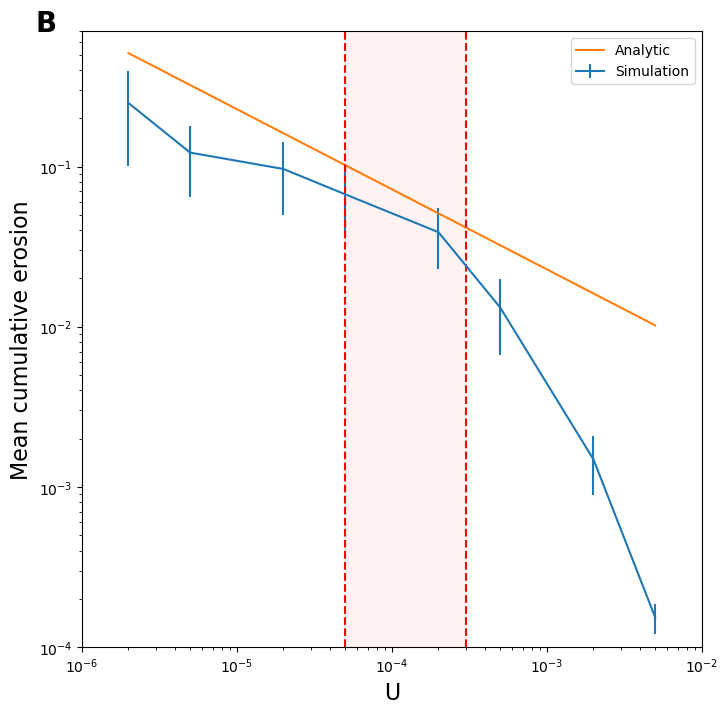

In [24]:
scaling_param_name="U"
param_to_plot="Mean_Age"
paramname="Mean cumulative erosion"

figure=plt.figure(1, figsize=(8,8))
figure.patch.set_facecolor('white')
figure.patch.set_alpha(0)

cletodelete=[]
for cle in trace_U:
    if len(trace_U[cle])==0:
        cletodelete.append(cle)
for cle in cletodelete:
    del trace_U[cle]
df_trace_U = pd.DataFrame(trace_U,index = trace_U["U"])
df_trace_U.sort_values(by = "U", inplace = True)
plt.errorbar(df_trace_U[scaling_param_name], df_trace_U[param_to_plot+'_mean'], df_trace_U[param_to_plot+'_variance'],label="Simulation")

plt.plot(U,Z_U,label="Analytic")
plt.text(x=0.0000005,y=0.7,s="B",fontweight='bold',fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(paramname, fontsize = 16)
plt.xlabel(scaling_param_name, fontsize = 16)
plt.axvline(x=u_min,color="red",ls="--")
plt.axvline(x=u_max,color="red",ls="--")
plt.legend()
plt.ylim(1e-4,0.7)
plt.xlim(1e-6,1e-2)
x=np.arange(u_min,u_max,0.000000001)
y1=0.7
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='red')

plt.savefig('Mean_Age_U.png', dpi=200, bbox_inches='tight')

## Scaling fertility (w) in function of v

In [25]:
V=[5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
Q_V=[]
Q_V_SYM=[]
mu=4*N*u
for i in V :
    rho=(N*i*d)/(2*h)
    z_bar=np.sqrt(rho/(mu*alpha))
    x_bar=simpson(x_bar_func, 0, 10, 100)
    x2_bar=simpson(x2_bar_func, 0, 10, 100)
    x3_bar=simpson(x3_bar_func, 0, 10, 100)
    Q_V.append((2*x2_bar-x3_bar)/(x_bar)) 
for i in range(len(Z_V_BAR)) :
    z_bar=Z_V_BAR[i]
    x_bar=X_V_BAR[i]
    x2_bar=simpson(x2_bar_func_1, 0, 10, 100)
    x3_bar=simpson(x3_bar_func_1, 0, 10, 100)
    Q_V_SYM.append((2*x2_bar-x3_bar)/(x_bar))

In [26]:
V=[5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
W_V=[]
W_V_BAR=[]
W_V_no_log=[]
mu=4*N*u
for i in V :
    rho=(N*i*d)/(2*h)
    z_bar=np.sqrt(rho/(mu*alpha))
    x_bar=simpson(x_bar_func, 0, 10, 100)
    x2_bar=simpson(x2_bar_func, 0, 10, 100)
    x3_bar=simpson(x3_bar_func, 0, 10, 100)
    q_bar=(2*x2_bar-x3_bar)/(x_bar)
    W_V.append(np.log(1-np.exp(-d*q_bar)))
    W_V_no_log.append(1-np.exp(-d*q_bar))
for i in range(len(Z_V_BAR)) :
    W_V_BAR.append(np.log(1-np.exp(-d*Q_V_SYM[i])))

[0.9779544362831363, 0.9776375135862605, 0.9762081884676365, 0.9745318475920093, 0.9626037143714012, 0.9200854579320972, 0.5954009579722137, 0.4450697232101982]


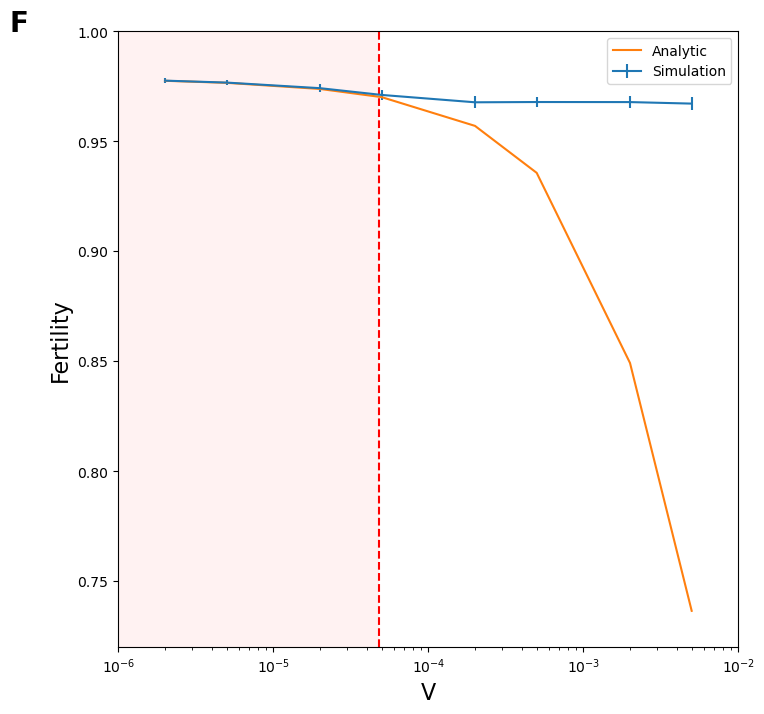

In [27]:
scaling_param_name="V"
param_to_plot="Fertility_rate"
paramname="Fertility rate"

param_to_plot_1="fertility_analytic"
paramname_1="Fertility"

plt.figure(1, figsize=(8,8))
figure.patch.set_facecolor('white')
figure.patch.set_alpha(0)

cletodelete=[]
for cle in trace_V_log:
    if len(trace_V_log[cle])==0:
        cletodelete.append(cle)
for cle in cletodelete:
    del trace_V_log[cle]
df_trace_V_log = pd.DataFrame(trace_V_log,index = trace_V_log["V"])
df_trace_V_log.sort_values(by = "V", inplace = True)

cletodelete=[]
for cle in trace_V:
    if len(trace_V[cle])==0:
        cletodelete.append(cle)
for cle in cletodelete:
    del trace_V[cle]
df_trace_V = pd.DataFrame(trace_V,index = trace_V["V"])
df_trace_V.sort_values(by = "V", inplace = True)
plt.errorbar(df_trace_V[scaling_param_name], df_trace_V[param_to_plot_1+'_mean'], df_trace_V[param_to_plot_1+'_variance'],label="Simulation")

W1_V=[]
for j in df_trace_V_log[scaling_param_name]:
    z_bar=df_trace_V_log["Mean_Age_mean"][j]
    x_bar=simpson(x_bar_func, 0, 10, 100)
    x2_bar=simpson(x2_bar_func, 0, 10, 100)
    x3_bar=simpson(x3_bar_func, 0, 10, 100)
    q_bar=((2*x2_bar-x3_bar)/(x_bar))
    W1_V.append(1-np.exp(-d*q_bar))
print(W1_V)

plt.text(x=0.0000002,y=1,s="F",fontweight='bold',fontsize=20)
plt.plot(V,W_V_no_log,label="Analytic")
plt.xscale('log')
plt.ylabel(paramname_1, fontsize = 16)
plt.xlabel(scaling_param_name, fontsize = 16)
plt.axvline(x=v_min,color="red",ls="--")
plt.axvline(x=v_max,color="red",ls="--")
plt.legend(loc='best')
plt.ylim(0.72,1)
plt.xlim(1e-6,1e-2)
x=np.arange(v_min,v_max,0.000000001)
y1=1
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='red')

plt.savefig('log_fertility_V.png', dpi=200, bbox_inches='tight')

## Scaling fertility (w) in function of u

In [28]:
U=[5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
Q_U=[]
Q_U_SYM=[]
rho=(N*v*d)/(2*h)
for i in U :
    mu=4*N*i
    z_bar=np.sqrt(rho/(mu*alpha))
    x_bar=simpson(x_bar_func, 0, 10, 100)
    x2_bar=simpson(x2_bar_func, 0, 10, 100)
    x3_bar=simpson(x3_bar_func, 0, 10, 100)
    Q_U.append((2*x2_bar-x3_bar)/(x_bar))
for i in range(len(Z_U_BAR)) :
    z_bar=Z_U_BAR[i]
    x_bar=X_U_BAR[i]
    x2_bar=simpson(x2_bar_func_1, 0, 10, 100)
    x3_bar=simpson(x3_bar_func_1, 0, 10, 100)
    Q_U_SYM.append((2*x2_bar-x3_bar)/(x_bar))

In [29]:
U=[5e-3,2e-3,5e-4,2e-4,5e-5,2e-5,5e-6,2e-6]
W_U=[]
W_U_BAR=[]
W_U_no_log=[]
rho=(N*v*d)/(2*h)
for i in U :
    mu=4*N*i
    z_bar=np.sqrt(rho/(mu*alpha))
    x_bar=simpson(x_bar_func, 0, 10, 100)
    x2_bar=simpson(x2_bar_func, 0, 10, 100)
    x3_bar=simpson(x3_bar_func, 0, 10, 100)
    q_bar=(2*x2_bar-x3_bar)/(x_bar)
    W_U.append(np.log(1-np.exp(-d*q_bar)))
    W_U_no_log.append(1-np.exp(-d*q_bar))
for i in range(len(Z_U_BAR)) :
    W_U_BAR.append(np.log(1-np.exp(-d*Q_U_SYM[i])))

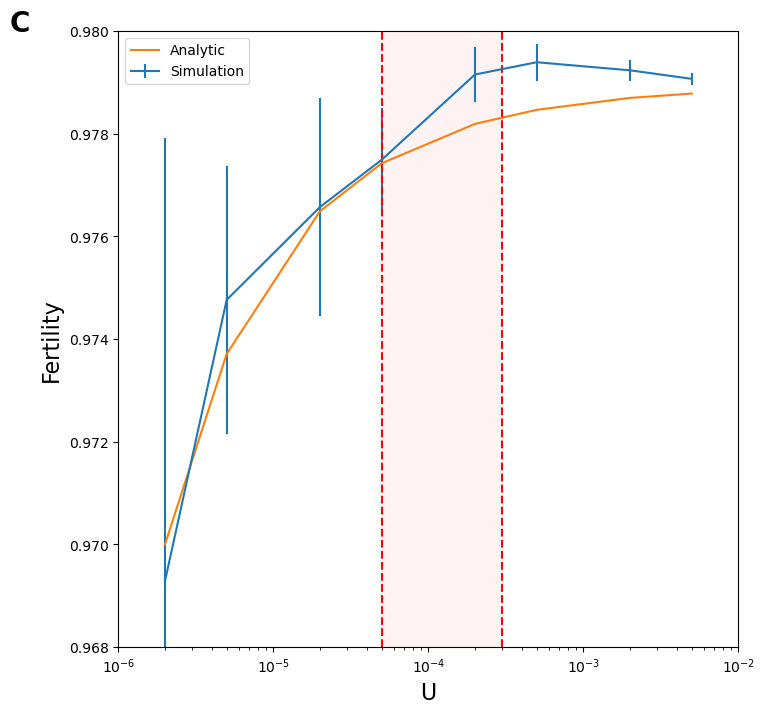

In [30]:
scaling_param_name="U"
param_to_plot="Fertility_rate"
paramname="Fertility rate"

param_to_plot_1="fertility_analytic"
paramname_1="log(Fertility)"
paramname_1="Fertility"

plt.figure(1, figsize=(8,8))
figure.patch.set_facecolor('white')
figure.patch.set_alpha(0)

cletodelete=[]
for cle in trace_U_log:
    if len(trace_U_log[cle])==0:
        cletodelete.append(cle)
for cle in cletodelete:
    del trace_U_log[cle]

df_trace_U_log = pd.DataFrame(trace_U_log,index = trace_U_log["U"])
df_trace_U_log.sort_values(by = "U", inplace = True)

cletodelete=[]
for cle in trace_U:
    if len(trace_U[cle])==0:
        cletodelete.append(cle)
for cle in cletodelete:
    del trace_U[cle]

df_trace_U = pd.DataFrame(trace_U,index = trace_U["U"])
df_trace_U.sort_values(by = "U", inplace = True)
plt.errorbar(df_trace_U[scaling_param_name], df_trace_U[param_to_plot_1+'_mean'], df_trace_U[param_to_plot_1+'_variance'],label="Simulation")

W1_U=[]
for j in df_trace_U_log[scaling_param_name]:
    z_bar=df_trace_U_log["Mean_Age_mean"][j]
    x_bar=simpson(x_bar_func, 0, 10, 100)
    x2_bar=simpson(x2_bar_func, 0, 10, 100)
    x3_bar=simpson(x3_bar_func, 0, 10, 100)
    q_bar=((2*x2_bar-x3_bar)/(x_bar))
    W1_U.append(1-np.exp(-d*q_bar))

plt.text(x=0.0000002,y=0.98,s="C",fontweight='bold',fontsize=20)
plt.plot(U,W_U_no_log,label="Analytic")
plt.xscale('log')
plt.ylabel(paramname_1, fontsize = 16)
plt.xlabel(scaling_param_name, fontsize = 16)
plt.axvline(x=u_min,color="red",ls="--")
plt.axvline(x=u_max,color="red",ls="--")
plt.legend(loc="best")
plt.ylim(0.968,0.98)
plt.xlim(1e-6,1e-2)
x=np.arange(u_min,u_max,0.000000001)
y1=1
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='red')

plt.savefig('log_fertility_U.png', dpi=200, bbox_inches='tight')

## All the scaling printed before in one figure

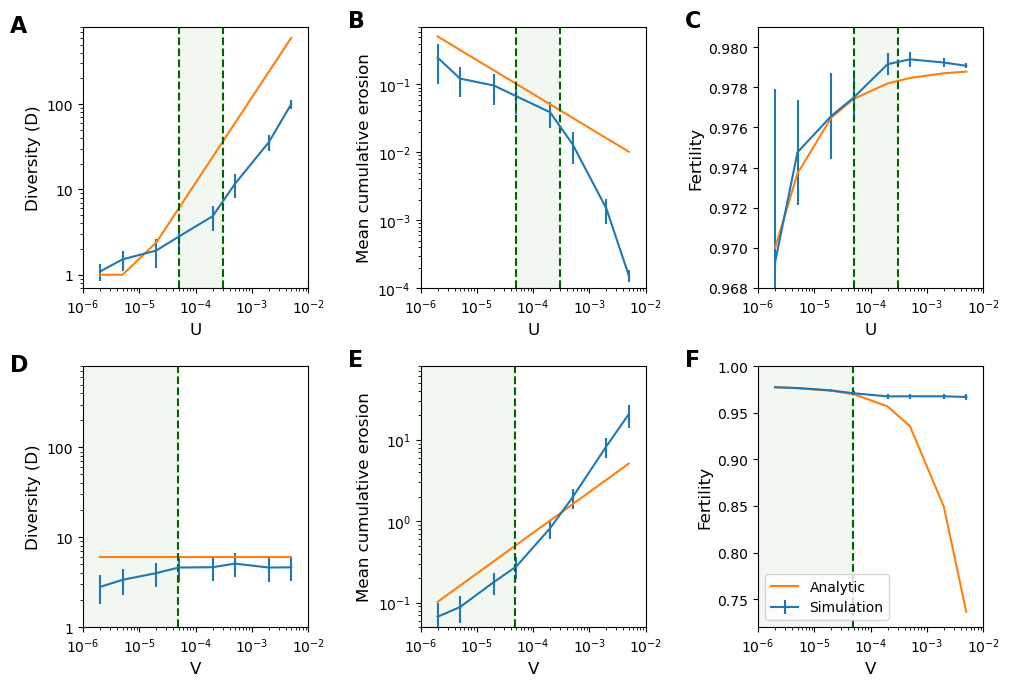

In [39]:
figure_D_U_V=plt.figure(figsize=(9,6))
figure_D_U_V.patch.set_facecolor('white')
figure_D_U_V.patch.set_alpha(0)
plt.subplots_adjust(left=1, bottom=1, right=2, top=2, wspace=0.5, hspace=0.3)


plt.subplot(2,3,1)
scaling_param_name="U"
param_to_plot="Diversity"
paramname="Diversity (D)"
plt.errorbar(df_trace_U[scaling_param_name], df_trace_U[param_to_plot+'_mean'], df_trace_U[param_to_plot+'_variance'],label="Simulation")
plt.text(x=0.00000005,y=700,s="A",fontweight='bold',fontsize=16)
plt.plot(U,D_U,label="Analytic")
plt.xscale('log')
plt.yscale('log')
ax=plt.gca()
fmtr = mticker.StrMethodFormatter('{x:.0f}')
ax.yaxis.set_major_formatter(fmtr)
plt.ylabel(paramname, fontsize = 12)
plt.xlabel(scaling_param_name, fontsize = 12)
plt.axvline(x=u_min,color='darkgreen',ls="--")
plt.axvline(x=u_max,color='darkgreen',ls="--")
plt.ylim(0.7,800)
plt.xlim(1e-6,1e-2)
x=np.arange(u_min,u_max,0.000000001)
y1=800
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='darkgreen')


plt.subplot(2,3,4)
scaling_param_name="V"
param_to_plot="Diversity"
paramname="Diversity (D)"
plt.errorbar(df_trace_V[scaling_param_name], df_trace_V[param_to_plot+'_mean'], df_trace_V[param_to_plot+'_variance'],label="Simulation")
plt.text(x=0.00000005,y=700,s="D",fontweight='bold',fontsize=16)
plt.plot(V,D_V,label="Analytic")
plt.xscale('log')
plt.yscale('log')
ax=plt.gca()
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
plt.ylabel(paramname, fontsize = 12)
plt.xlabel(scaling_param_name, fontsize = 12)
plt.axvline(x=v_min,color='darkgreen',ls="--")
plt.axvline(x=v_max,color='darkgreen',ls="--")
plt.ylim(1,800)
plt.xlim(1e-6,1e-2)
color_x=[1e-6,v_max]
color_y=[1,800]
x=np.arange(1e-6,v_max,0.000000001)
y1=800
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='darkgreen')


plt.subplot(2,3,2)
scaling_param_name="U"
param_to_plot="Mean_Age"
paramname="Mean cumulative erosion"
plt.errorbar(df_trace_U[scaling_param_name], df_trace_U[param_to_plot+'_mean'], df_trace_U[param_to_plot+'_variance'],label="Simulation")
plt.plot(U,Z_U,label="Analytic")
plt.text(x=0.00000005,y=0.7,s="B",fontweight='bold',fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(paramname, fontsize = 12)
plt.xlabel(scaling_param_name, fontsize = 12)
plt.axvline(x=u_min,color="darkgreen",ls="--")
plt.axvline(x=u_max,color="darkgreen",ls="--")
plt.ylim(1e-4,0.7)
plt.xlim(1e-6,1e-2)
x=np.arange(u_min,u_max,0.000000001)
y1=0.7
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='darkgreen')


plt.subplot(2,3,5)
scaling_param_name="V"
param_to_plot="Mean_Age"
paramname="Mean cumulative erosion"
plt.errorbar(df_trace_V[scaling_param_name], df_trace_V[param_to_plot+'_mean'], df_trace_V[param_to_plot+'_variance'],label="Simulation")
plt.plot(V,Z_V,label="Analytic")
plt.text(x=0.00000005,y=80,s="E",fontweight='bold',fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(paramname, fontsize = 12)
plt.xlabel(scaling_param_name, fontsize = 12)
plt.axvline(x=v_min,color='darkgreen',ls="--")
plt.axvline(x=v_max,color='darkgreen',ls="--")
plt.ylim(0.05,80)
plt.xlim(1e-6,1e-2)
x=np.arange(v_min,v_max,0.000000001)
y1=80
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='darkgreen')

plt.subplot(2,3,3)
scaling_param_name="U"
param_to_plot="Fertility_rate"
paramname="Fertility rate"
plt.errorbar(df_trace_U[scaling_param_name], df_trace_U[param_to_plot_1+'_mean'], df_trace_U[param_to_plot_1+'_variance'],label="Simulation")
plt.text(x=0.00000005,y=0.981,s="C",fontweight='bold',fontsize=16)
plt.plot(U,W_U_no_log,label="Analytic")
plt.xscale('log')
plt.ylabel(paramname_1, fontsize = 12)
plt.xlabel(scaling_param_name, fontsize = 12)
plt.axvline(x=u_min,color='darkgreen',ls="--")
plt.axvline(x=u_max,color='darkgreen',ls="--")
plt.ylim(0.968,0.981)
plt.xlim(1e-6,1e-2)
x=np.arange(u_min,u_max,0.000000001)
y1=1
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='darkgreen')


plt.subplot(2,3,6)
scaling_param_name="V"
param_to_plot="Fertility_rate"
paramname="Fertility rate"
plt.errorbar(df_trace_V[scaling_param_name], df_trace_V[param_to_plot_1+'_mean'], df_trace_V[param_to_plot_1+'_variance'],label="Simulation")
plt.text(x=0.00000005,y=1,s="F",fontweight='bold',fontsize=16)
plt.plot(V,W_V_no_log,label="Analytic")
plt.xscale('log')
plt.ylabel(paramname_1, fontsize = 12)
plt.xlabel(scaling_param_name, fontsize = 12)
plt.axvline(x=v_min,color='darkgreen',ls="--")
plt.axvline(x=v_max,color='darkgreen',ls="--")
plt.ylim(0.72,1)
plt.xlim(1e-6,1e-2)
x=np.arange(v_min,v_max,0.000000001)
y1=1
y2=0
plt.fill_between(x,y1,y2,alpha=0.05,facecolor='darkgreen')
plt.legend(loc='best')

plt.savefig('Fig_1.png', dpi=200, bbox_inches='tight')

**Caption : Summary statistics as a function of the Prdm9 mutation rate u (v = 2e-6) and the
target mutation rate v (u = 5e−5).** Study of the Diversity (D) as a function of u (A) and v (D), the
mean erosion at equilibrium as a function of u (B) and v (E) and the log fitness as a function of u (C) and v
(F). Each graph represent the computer simulations with the variance for each run (blue) and the analytical
approximations (orange). The area colored in green correspond to the area where the analytical model
verifies the assumptions of high diversity, low erosion and strong selection